In [1]:


import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization,LSTM
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_gender_final.csv')

In [4]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(31584, 2377)

In [6]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [7]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['female', 'male'], dtype=object)]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376), (26846, 2), (4738, 2376), (4738, 2))

In [9]:
scaler = StandardScaler()

In [10]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((26846, 2376),
 (3553, 2376),
 (1185, 2376),
 (26846, 2376),
 (3553, 2376),
 (1185, 2376))

In [11]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376), (26846, 2), (3553, 2376), (3553, 2))

In [12]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val = np.expand_dims(x_val, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((26846, 2376, 1), (26846, 2), (3553, 2376, 1), (3553, 2))

In [13]:
optimizer = keras.optimizers.Adam(lr=0.0005)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model=Sequential()

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 256)         1536      
                                                                 
 batch_normalization (BatchN  (None, 2376, 256)        1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 256)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 256)         327936    
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 256)        1024      
 hNormalization)                                                 
                                                        

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [16]:
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
839/839 [==============================] - 76s 70ms/step - loss: 0.4865 - accuracy: 0.7727 - val_loss: 0.3971 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 2/100
839/839 [==============================] - 55s 65ms/step - loss: 0.3163 - accuracy: 0.8662 - val_loss: 0.2608 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 3/100
839/839 [==============================] - 54s 65ms/step - loss: 0.2856 - accuracy: 0.8804 - val_loss: 0.2447 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 4/100
839/839 [==============================] - 54s 65ms/step - loss: 0.2475 - accuracy: 0.9000 - val_loss: 0.2221 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 5/100
839/839 [==============================] - 55s 65ms/step - loss: 0.2291 - accuracy: 0.9057 - val_loss: 0.2774 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 6/100
839/839 [==============================] - 54s 65ms/step - loss: 0.2063 - accuracy: 0.9173 - val_loss: 0.3690 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 7/100
839/839 [==============================]

In [17]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

112/112 [==============================] - 2s 19ms/step - loss: 0.0254 - accuracy: 0.9901
Accuracy of our model on test data :  99.01491403579712 %


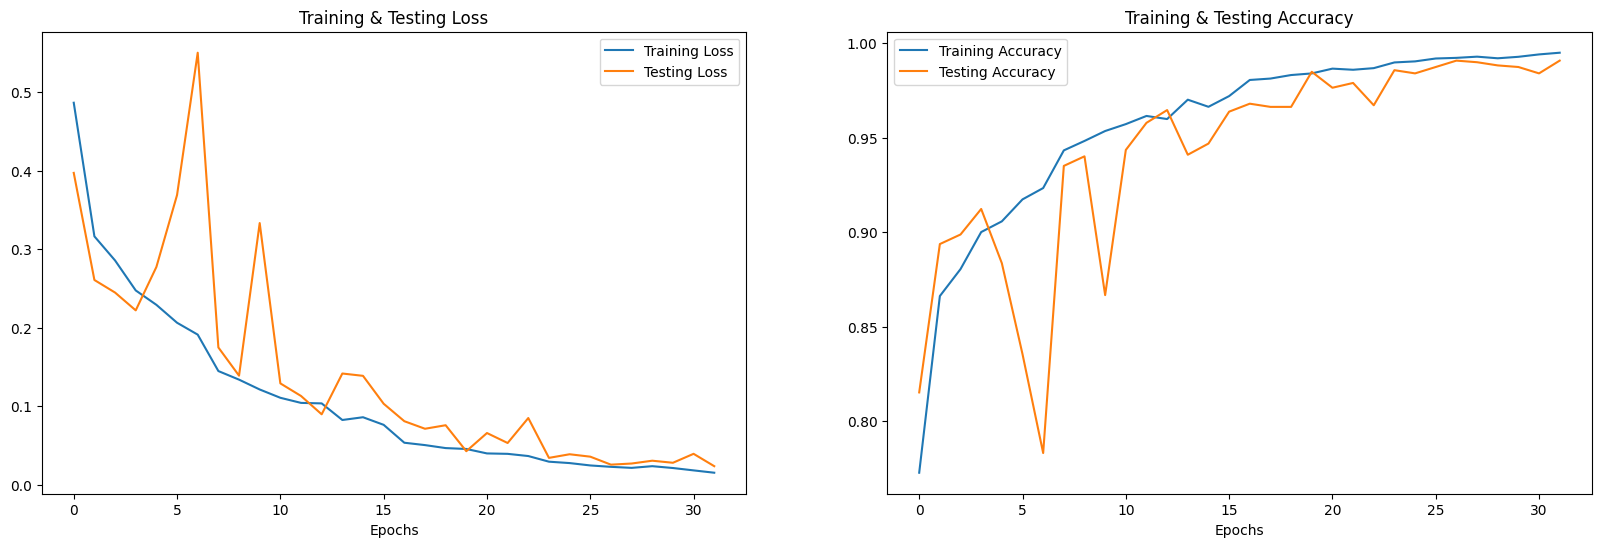

In [18]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [19]:
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

112/112 [==============================] - 2s 17ms/step


In [20]:
pred_test=model.predict(x_test)

112/112 [==============================] - 2s 17ms/step


In [21]:
df_temp = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp['Predicted Labels'] = y_pred.flatten()
df_temp['Actual Labels'] = y_test.flatten()

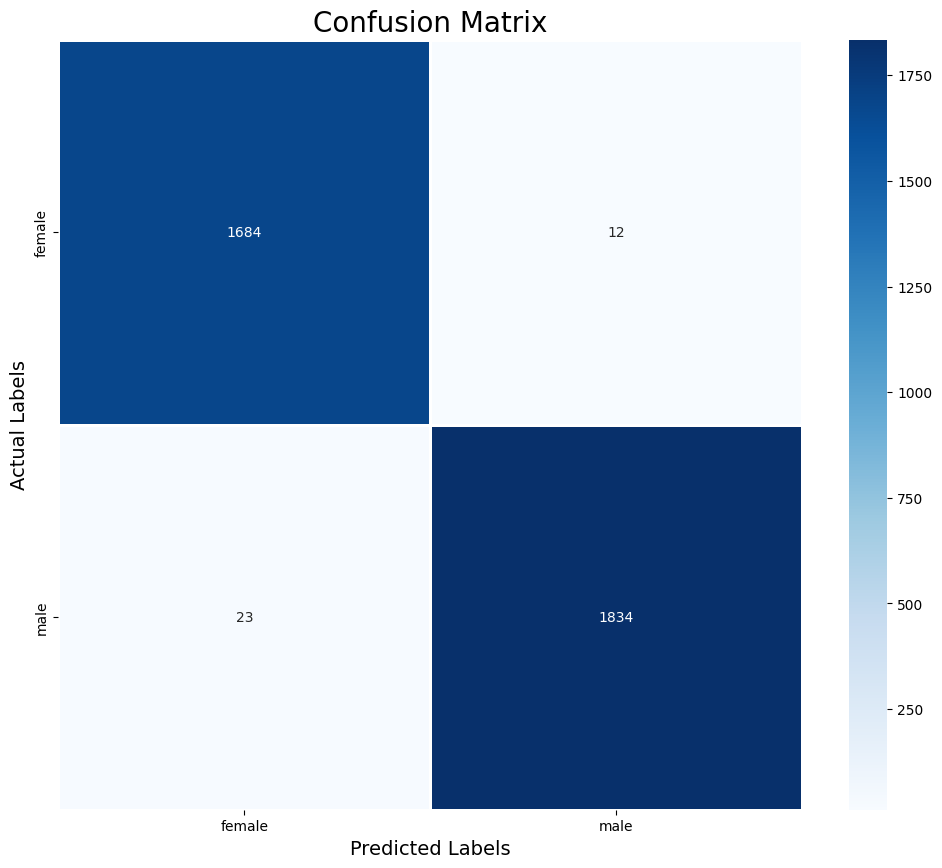

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [23]:
print(classification_report(y_test, y_pred, target_names=['male','female']))

              precision    recall  f1-score   support

        male       0.99      0.99      0.99      1696
      female       0.99      0.99      0.99      1857

    accuracy                           0.99      3553
   macro avg       0.99      0.99      0.99      3553
weighted avg       0.99      0.99      0.99      3553



## From voice features and predicted gender, predict age

In [24]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_age_final.csv')

In [25]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [26]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [27]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [28]:
Z=model.predict(X1)

633/633 [==============================] - 11s 17ms/step


In [29]:
Z = encoder.inverse_transform(Z)

In [30]:
Z = Z.flatten()

In [31]:
Features = pd.DataFrame(X)
Features['predicted emotion'] = Z
Features['labels'] = Y

In [32]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted emotion,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
1,0.035645,0.064453,0.087402,0.078125,0.065918,0.047363,0.035156,0.041016,0.042969,0.041504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,thirties
3,0.037598,0.057617,0.083008,0.077637,0.060547,0.045898,0.026855,0.021973,0.025391,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,thirties
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male,thirties
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,0.020020,0.040527,0.060059,0.062500,0.058105,0.046875,0.037598,0.042480,0.044922,0.047363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20224,0.010742,0.017578,0.023926,0.027344,0.033691,0.050293,0.069824,0.083984,0.093750,0.086914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20225,0.040039,0.070801,0.101074,0.104004,0.115723,0.110840,0.106934,0.105469,0.096680,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties
20226,0.011719,0.019043,0.024414,0.031250,0.048340,0.070312,0.087891,0.099609,0.093262,0.080078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female,twenties


In [33]:
Features['predicted emotion'] = Features['predicted emotion'].astype('category').cat.codes

In [34]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [35]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['fifties', 'forties', 'seventies', 'sixties', 'thirties',
        'twenties'], dtype=object)]

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (3035, 2377), (3035, 6))

In [37]:
scaler = StandardScaler()

In [38]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((17193, 2377),
 (2276, 2377),
 (759, 2377),
 (17193, 2377),
 (2276, 2377),
 (759, 2377))

In [39]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (2276, 2377), (2276, 6))

In [40]:
optimizer = keras.optimizers.Adam(lr=0.0005)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [41]:
model2=Sequential()

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model2.add(Dropout(0.2))

model2.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(6, activation='softmax'))
model2.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2377, 256)         1536      
                                                                 
 batch_normalization_5 (Batc  (None, 2377, 256)        1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1189, 256)        0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1189, 256)         327936    
                                                                 
 batch_normalization_6 (Batc  (None, 1189, 256)        1024      
 hNormalization)                                                 
                                                      

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [43]:
history2=model2.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
538/538 [==============================] - 43s 69ms/step - loss: 1.6885 - accuracy: 0.3207 - val_loss: 1.5078 - val_accuracy: 0.3623 - lr: 0.0010
Epoch 2/100
538/538 [==============================] - 34s 64ms/step - loss: 1.4758 - accuracy: 0.3637 - val_loss: 1.5196 - val_accuracy: 0.3412 - lr: 0.0010
Epoch 3/100
538/538 [==============================] - 34s 64ms/step - loss: 1.3847 - accuracy: 0.3957 - val_loss: 1.4079 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 4/100
538/538 [==============================] - 34s 63ms/step - loss: 1.3136 - accuracy: 0.4368 - val_loss: 2.1614 - val_accuracy: 0.3202 - lr: 0.0010
Epoch 5/100
538/538 [==============================] - 35s 64ms/step - loss: 1.3646 - accuracy: 0.4135 - val_loss: 1.4088 - val_accuracy: 0.4097 - lr: 0.0010
Epoch 6/100
538/538 [==============================] - 35s 64ms/step - loss: 1.2813 - accuracy: 0.4538 - val_loss: 1.4062 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 7/100
538/538 [==============================]

In [44]:
print("Accuracy of our model on test data : " , model2.evaluate(x_test,y_test)[1]*100 , "%")

72/72 [==============================] - 2s 21ms/step - loss: 0.1956 - accuracy: 0.9416
Accuracy of our model on test data :  94.156414270401 %


In [45]:
pred_test = model2.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

72/72 [==============================] - 1s 17ms/step


In [46]:
pred_test=model2.predict(x_test)

72/72 [==============================] - 1s 18ms/step


In [47]:
df_temp2 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp2['Predicted Labels'] = y_pred.flatten()
df_temp2['Actual Labels'] = y_test.flatten()

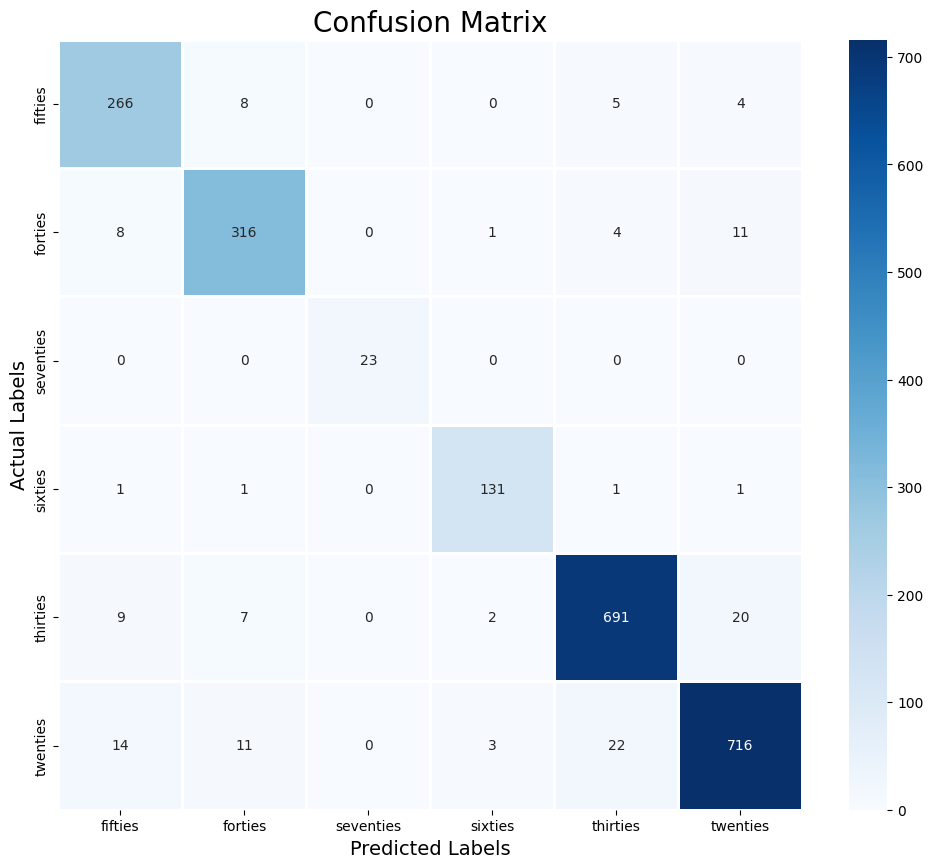

In [48]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

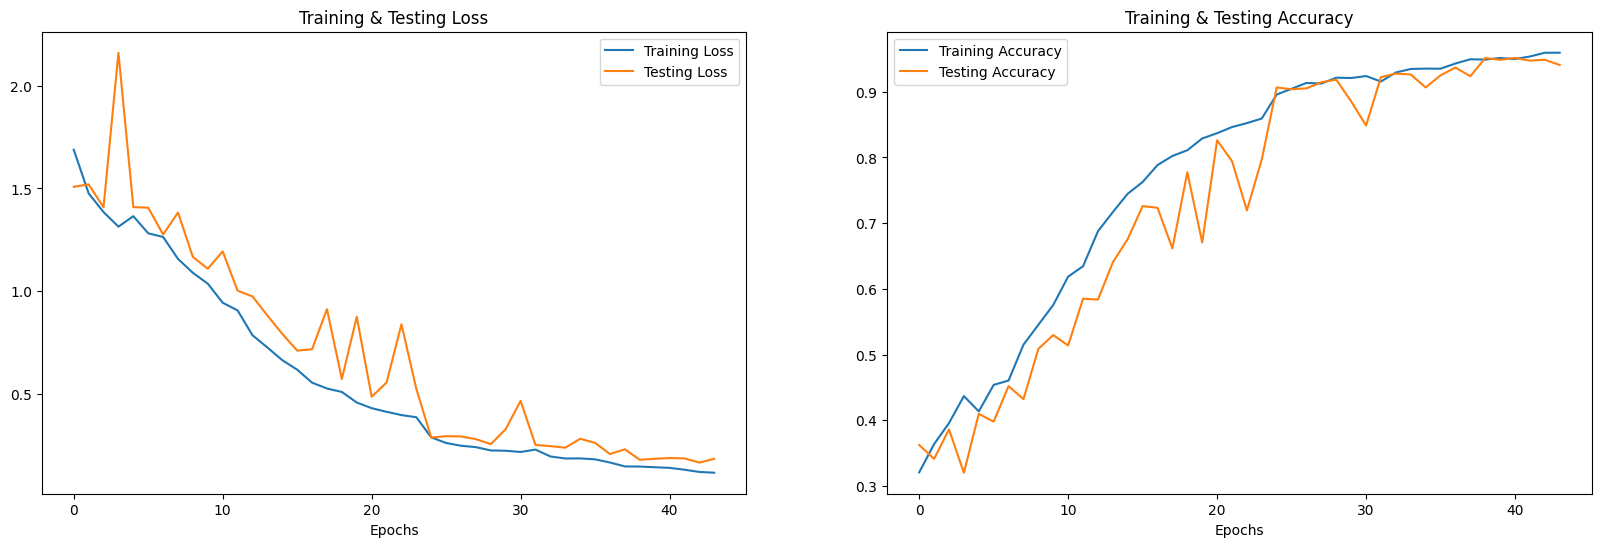

In [49]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
test_acc = history2.history['val_accuracy']
test_loss = history2.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [51]:
print(classification_report(y_test, y_pred, target_names=['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']))

              precision    recall  f1-score   support

    twenties       0.89      0.94      0.92       283
    thirties       0.92      0.93      0.93       340
     forties       1.00      1.00      1.00        23
     fifties       0.96      0.97      0.96       135
     sixties       0.96      0.95      0.95       729
   seventies       0.95      0.93      0.94       766

    accuracy                           0.94      2276
   macro avg       0.95      0.95      0.95      2276
weighted avg       0.94      0.94      0.94      2276



## From voice features and predicted age, predict emotion

In [52]:
Features = pd.read_csv('/content/drive/MyDrive/Prism/features_emotion_final.csv')

In [53]:
Features = Features.fillna(0)
print(Features.isna().any())
Features.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(20228, 2377)

In [54]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [55]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X)
X1 = np.expand_dims(X1, axis=2)

In [56]:
Z=model2.predict(X1)

633/633 [==============================] - 12s 19ms/step


In [57]:
Z = encoder.inverse_transform(Z)

In [58]:
Z = Z.flatten()

In [59]:
Features = pd.DataFrame(X)
Features['predicted gender'] = Z
Features['labels'] = Y

In [60]:
Features['predicted gender'] = Features['predicted gender'].astype('category').cat.codes

In [61]:
Features

,0,1,2,3,4,5,6,7,8,9,...,2368,2369,2370,2371,2372,2373,2374,2375,predicted gender,labels
0,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,happiness
1,0.032715,0.059570,0.076660,0.065918,0.053223,0.031738,0.019531,0.020508,0.020508,0.023926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,happiness
2,0.036621,0.057617,0.082031,0.076660,0.060547,0.044922,0.025879,0.020996,0.024414,0.028320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,happiness
3,0.036621,0.057617,0.083008,0.079590,0.064453,0.050781,0.032715,0.028809,0.038086,0.040039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,happiness
4,0.014648,0.026367,0.039062,0.043457,0.043945,0.039551,0.067383,0.098633,0.099121,0.107910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,happiness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,0.020996,0.042480,0.063965,0.067383,0.062012,0.048828,0.036621,0.041504,0.042969,0.047363,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,anxiety/fear
20224,0.010742,0.017578,0.023926,0.027344,0.033691,0.050293,0.069824,0.083984,0.093750,0.086914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,neutral
20225,0.039062,0.068848,0.100098,0.098633,0.108887,0.101074,0.095215,0.097168,0.091797,0.085938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,neutral
20226,0.011719,0.019043,0.024414,0.031250,0.048340,0.070312,0.087891,0.099609,0.093262,0.080078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,neutral


In [62]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [63]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoder.categories_

[array(['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sad'],
       dtype=object)]

In [64]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.15, random_state=30, shuffle=True,stratify=Y)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (3035, 2377), (3035, 6))

In [65]:
scaler = StandardScaler()

In [66]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, random_state=30, test_size=0.25, shuffle=True,stratify=y_test)
x_train.shape, x_test.shape, x_val.shape, x_train.shape, x_test.shape, x_val.shape

((17193, 2377),
 (2276, 2377),
 (759, 2377),
 (17193, 2377),
 (2276, 2377),
 (759, 2377))

In [67]:
x_train = scaler.fit_transform(x_train)
x_val=scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17193, 2377), (17193, 6), (2276, 2377), (2276, 6))

In [68]:
optimizer = keras.optimizers.Adam(lr=0.0005)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [69]:
model3=Sequential()

model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model3.add(Dropout(0.2))

model3.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model3.add(Flatten())
model3.add(Dense(32, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Dense(6, activation='softmax'))
model3.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2377, 256)         1536      
                                                                 
 batch_normalization_10 (Bat  (None, 2377, 256)        1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 1189, 256)        0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 1189, 256)         327936    
                                                                 
 batch_normalization_11 (Bat  (None, 1189, 256)        1024      
 chNormalization)                                                
                                                      

In [70]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=5, start_from_epoch=20)
callbacks=[learning_rate_reduction,early_stop]



In [71]:
history3=model3.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/100
538/538 [==============================] - 44s 67ms/step - loss: 1.5865 - accuracy: 0.3645 - val_loss: 1.5472 - val_accuracy: 0.4058 - lr: 0.0010
Epoch 2/100
538/538 [==============================] - 35s 65ms/step - loss: 1.4202 - accuracy: 0.4265 - val_loss: 1.3804 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 3/100
538/538 [==============================] - 34s 64ms/step - loss: 1.3449 - accuracy: 0.4620 - val_loss: 1.3021 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 4/100
538/538 [==============================] - 35s 65ms/step - loss: 1.2738 - accuracy: 0.4956 - val_loss: 1.4460 - val_accuracy: 0.4058 - lr: 0.0010
Epoch 5/100
538/538 [==============================] - 34s 64ms/step - loss: 1.2163 - accuracy: 0.5204 - val_loss: 1.3869 - val_accuracy: 0.4480 - lr: 0.0010
Epoch 6/100
538/538 [==============================] - 36s 67ms/step - loss: 1.1786 - accuracy: 0.5359 - val_loss: 1.1781 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 7/100
538/538 [==============================]

In [72]:
print("Accuracy of our model on test data : " , model3.evaluate(x_test,y_test)[1]*100 , "%")

72/72 [==============================] - 1s 20ms/step - loss: 0.1951 - accuracy: 0.9380
Accuracy of our model on test data :  93.80491971969604 %


In [73]:
pred_test = model3.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

72/72 [==============================] - 2s 18ms/step


In [74]:
pred_test=model3.predict(x_test)

72/72 [==============================] - 1s 17ms/step


In [75]:
df_temp3 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_temp3['Predicted Labels'] = y_pred.flatten()
df_temp3['Actual Labels'] = y_test.flatten()

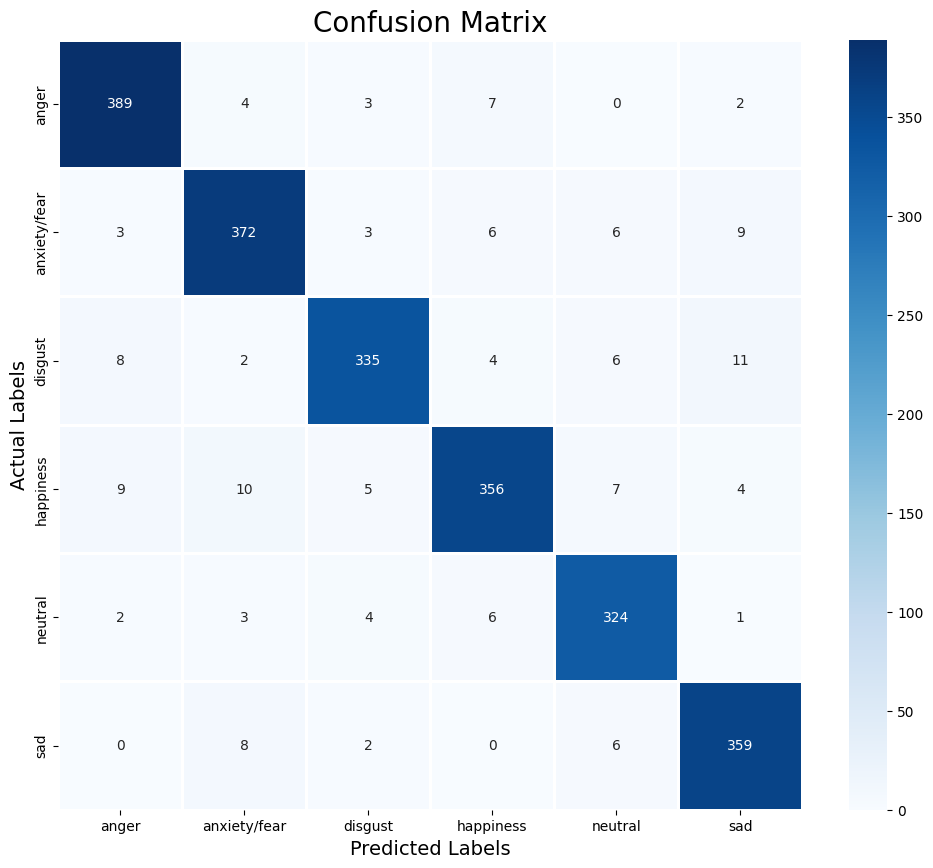

In [76]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

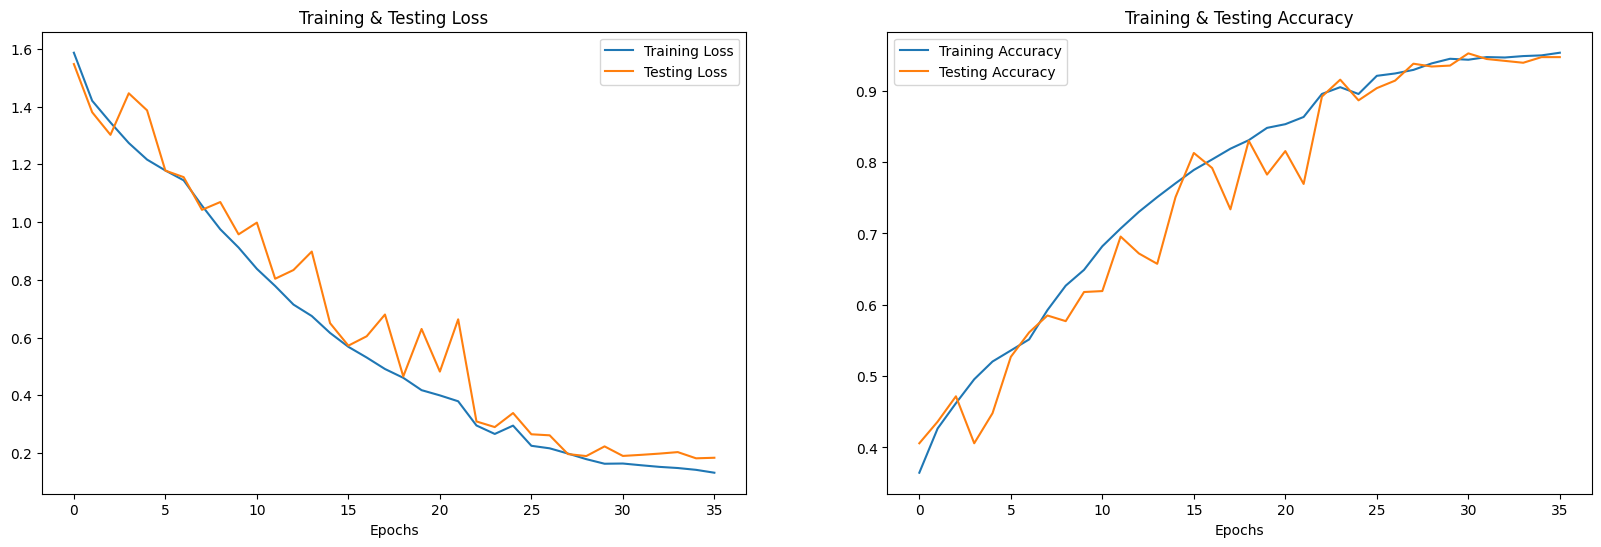

In [77]:
epochs = [i for i in range(early_stop.stopped_epoch+1) ]
fig , ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
test_acc = history3.history['val_accuracy']
test_loss = history3.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [78]:
print(classification_report(y_test, y_pred, target_names=['anger', 'anxiety/fear', 'disgust', 'happiness', 'neutral', 'sad']))

              precision    recall  f1-score   support

       anger       0.95      0.96      0.95       405
anxiety/fear       0.93      0.93      0.93       399
     disgust       0.95      0.92      0.93       366
   happiness       0.94      0.91      0.92       391
     neutral       0.93      0.95      0.94       340
         sad       0.93      0.96      0.94       375

    accuracy                           0.94      2276
   macro avg       0.94      0.94      0.94      2276
weighted avg       0.94      0.94      0.94      2276

